# Introduction and overview

For given diffusivity $D(x)$, drift $a(x)$, reference path $\varphi(t)$, and tube radius $R(t)$, the module **PyTubular** allows to perturbatively evaluate the exit rate along the tube.

We here use the numpy implementation of the exit rate (contained in **PyTubular.numerical()**), to find the most probable path $\varphi^*$, defined as

\begin{align}
\varphi^* &:= \argmin_{\varphi} \int_{t_0}^{t_1}dt\,\alpha^{\varphi}_R(t),
\end{align}

For fixed total duration $[t_0,t_1]$ and endpoints $x_0 \equiv \varphi(t_0)$, $x_1 \equiv \varphi(t_1)$. We furthermore assume that the tube radius $R(t)$ is independent of time.

Note that in the process of numerically minimizing the integrated-exit-rate functional, we need to evaluate the exit rate along a lot of paths. We therefore based the code below on the numpy implementation of the exit rate below, as it evaluates faster as compared to the symbolic sympy implementation (which is contained in PyTubular.symbolic()).

To approximate the infinite-dimensional functional minimization problem above by a finite-dimensional minimization problem, we approximate the space of paths by a finite series of sin modes as

\begin{align}
\varphi(t) &= \sum_{n=1}^{N} \frac{c_n}{n^2} 
\sin\left[ 
    \pi n \frac{ t -t_0}{t_1-t_0}
    \right]
+ 
x_0 + (x_1 - x_0) \frac{t-t_0}{t_1-t_0}.
\end{align}

Every vector $(c_1, ..., c_N) \in \mathbb{R}^N$ defines a path that connects $\varphi(t_0) = x_0$ with $\varphi(t_1) = x_1$. 

In the following we substitute this parametrization in the integrated-exit-rate functional, and try to find coefficients $c_i$ such that the functional is minimized.

In [1]:
# imports of standard modules used
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cma
import h5py

# we change some plotting parameters, for more pretty plots
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
mpl.rcParams['xtick.major.pad']='10'
mpl.rcParams['ytick.major.pad']='7'
mpl.rc('xtick', labelsize=25) 
mpl.rc('ytick', labelsize=25) 
mpl.rcParams.update({'font.size': 25})
mpl.rcParams.update({'legend.fontsize': 15})

In [2]:
import PyTubular

In [3]:
# Set scales
L = 1. 
D0 = 1. 
tD = L**2/D0

# tube radius
R0 = 0.1

# left and right minimum of steady-state potential we consider
xL = -0.99627
xR =  1.00366

# temporal parameters for paths
t_initial = 0.
t_final = 1.0
DT = t_final - t_initial

# spatial parameters for paths
x_0 = xL
x_1 = xR
DX = x_1 - x_0

# we numerical evaluate the exit rate at Nt evenly spaced points
Nt = 20001
t_eval = np.linspace(t_initial,t_final,endpoint=True,num=Nt)

# number of modes for the representation of path space
N_modes = 40

# output filename for storing the results of our minimization
output_filename = 'most_probable_tube_radius_{0:3.2f}.h5'.format(R0)

In [4]:
# Define diffusivity and its spatial derivatives
D_func = lambda x: D0*( 5 - 1*np.cos(np.pi*x/L))/4.
dD_func = lambda x: D0 * 0.25*np.sin(np.pi*x/L) * np.pi/L
ddD_func = lambda x: D0 * 0.25*np.cos(np.pi*x/L) * (np.pi/L)**2
dddD_func = lambda x: -D0 * 0.25*np.sin(np.pi*x/L) * (np.pi/L)**3
ddddD_func = lambda x: -D0 * 0.25*np.cos(np.pi*x/L) * (np.pi/L)**4

D_functions = [D_func,dD_func,ddD_func,dddD_func,ddddD_func]

# Define drift and its spatial derivatives
a_func = np.vectorize( lambda x: D0/(20*L) + 8*D0*x/L**2 - 8*D0*x**3/L**4 )
da_func = np.vectorize( lambda x: 8*D0/L**2 - 24*D0*x**2/L**4 )
dda_func = np.vectorize( lambda x:  -48*D0*x/L**4 )
ddda_func = np.vectorize( lambda x:  -48*D0/L**4 )

a_functions = [a_func,da_func,dda_func,ddda_func]

# Define R(t) and d/dt [ln(R)] = (dR/dt) / R functions
R_function = np.vectorize( lambda t: R0 )
d_log_R_function = np.vectorize( lambda t: 0. )

In [5]:
order = 2 # we want to evaluate the exit rate to order R^2 beyond the free
# diffusion result, i.e. we want to include the terms at orders 1/R^2, 1/R,
# and R^0 (note that the term at order 1/R is identically zero).

parameters = {'a':a_functions,
                'D':D_functions,
                'R':R_function,
                'd_log_R':d_log_R_function,
                'order':order}

# Instantiate class with given drift, diffusivity, and radius function
pt = PyTubular.numerical(parameters=parameters)

# Alternatively one could instantiate the class without passing the parameters
# dictionary, and pass the functions individually:
'''
pt = PyTubular.numerical()

pt.set_a(a=a_functions)
pt.set_D(D=D_functions)
pt.set_R(R=R_function)
pt.set_d_log_R(d_log_R=d_log_R_function)
''';

In [6]:
def evaluate_action(coeffs, # these are the c_n from the introduction
                    full_output=False):
    global N_modes
    global t_eval
    #
    coeffs_renormalized = coeffs/np.arange(1,N_modes+1)**2
    #
    def path_function(t):
        #
        path = np.zeros([N_modes,len(t)],dtype=float)
        for i,c in enumerate(coeffs_renormalized):
            path[i] = c * np.sin(np.pi*(i+1)*(t-t_initial) /DT )
        #
        path = np.sum(path,axis=0)
        #
        path += x_0 + DX*(t-t_initial)/DT
        #
        return path
    #
    def dot_path_function(t):
        #
        dot_path = np.zeros([N_modes,len(t)],dtype=float)
        for i,c in enumerate(coeffs_renormalized):
            dot_path[i] = c * (i+1) * np.cos(np.pi*(i+1)*(t-t_initial)/DT )
        #
        dot_path = np.sum(dot_path,axis=0) * np.pi / DT
        #
        dot_path += DX/DT
        return dot_path
    #
    pt.set_path(path=path_function)
    pt.set_dot_path(dot_path=dot_path_function)
    #
    result = pt.eval_exit_rate(t=t_eval,
                        order=order)
    #
    action = np.trapz( result['exit_rate'] , t_eval)
    #
    if full_output:
        result['path'] = path_function(t_eval)
        result['dot_path'] = dot_path_function(t_eval)
        result['action'] = action
        return result
    else:
        return action

In [7]:
coeffs_opt, es = cma.fmin2(
                        evaluate_action, # functional we want to minimize
                        N_modes * [0], # initial guess is a straight line
                        .5, # initial variance for the cma algorithm
                        )

(7_w,15)-aCMA-ES (mu_w=4.5,w_1=34%) in dimension 40 (seed=179581, Fri Jan 12 12:11:20 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 2.918359333930145e+02 1.0e+00 4.75e-01  5e-01  5e-01 0:00.3
    2     30 3.005647352686256e+02 1.1e+00 4.60e-01  5e-01  5e-01 0:00.6
    3     45 2.932708828091767e+02 1.1e+00 4.52e-01  4e-01  5e-01 0:00.9
   13    195 2.754396454427720e+02 1.2e+00 4.14e-01  4e-01  4e-01 0:04.0
   27    405 2.718168197490176e+02 1.4e+00 3.73e-01  3e-01  4e-01 0:08.3
   44    660 2.710751536802846e+02 1.7e+00 4.49e-01  4e-01  5e-01 0:13.4
   64    960 2.725239563048531e+02 2.1e+00 4.70e-01  3e-01  5e-01 0:19.5
   88   1320 2.693875679735065e+02 2.4e+00 4.19e-01  3e-01  5e-01 0:26.8
  100   1500 2.687075629436592e+02 2.6e+00 3.53e-01  2e-01  4e-01 0:30.5
  130   1950 2.674651742942228e+02 3.1e+00 3.34e-01  2e-01  4e-01 0:39.5
  163   2445 2.656768586870419e+02 3.5e+00 2.79e-01  1e-01  3e-01 0:49.6
  200   3000 2.650015752328362e+0

In [8]:
# evaluate optimal path 
result = evaluate_action(
                        coeffs=coeffs_opt,
                        full_output=True
                                        )

further_output_parameters = {
                'coeffs':coeffs_opt,
                 'N_modes':N_modes,
                 #
                 't_final':t_final,
                 't_initial':t_initial,
                 #
                 'x_0':x_0,
                 'x_1':x_1,
                 #
                 'R0':R0,
                 }

for key, value in further_output_parameters.items():
    result[key] = value

with h5py.File(output_filename, 'w') as hf:
    for key, value in result.items():
        hf.create_dataset(name=str(key),data=value)

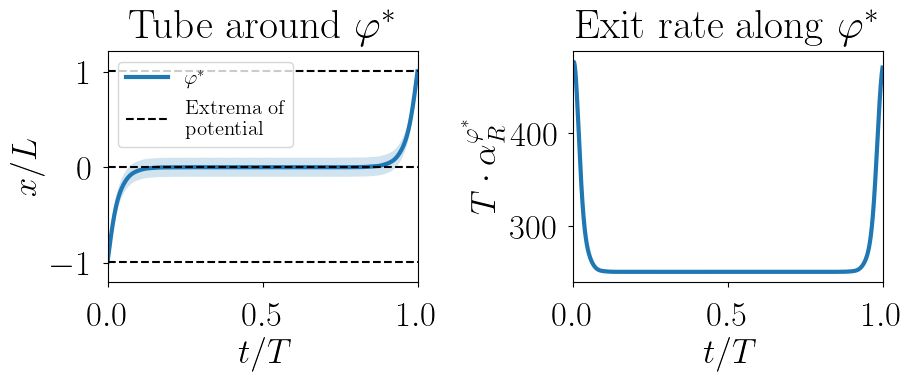

In [9]:
R_eval = result['R']
path_eval = result['path']
exit_rate_eval = result['exit_rate']


fig, axes = plt.subplots(1,2,figsize=(10,3))
fig.subplots_adjust(wspace=0.5)

y_title = 1.02
lw=3

ax = axes[0]
ax.set_title(r'Tube around $\varphi^*$',
                y=y_title)
ax.fill_between(t_eval,
        path_eval-R_eval,
        path_eval+R_eval,
               alpha=0.2)
ax.plot(t_eval,
        path_eval,
        label=r'$\varphi^*$',
        lw=lw)
ax.axhline(x_0,ls='--',color='black',
                label='Extrema of\npotential')
ax.axhline(x_1,ls='--',color='black')
ax.axhline(0.,ls='--',color='black')
ax.set_xlim(np.min(t_eval),np.max(t_eval))
ax.legend(loc='best')
ax.set_xlabel(r'$t/T$')
ax.set_ylabel(r'$x/L$')

ax = axes[1]
ax.set_title(r'Exit rate along $\varphi^*$',
                y=y_title)
ax.plot(t_eval,exit_rate_eval,
        lw=lw)
ax.set_xlabel(r'$t/T$')
ax.set_ylabel(r'$T \cdot \alpha_{R}^{\varphi^*} $')
ax.set_xlim(np.min(t_eval),np.max(t_eval))

plt.show()
plt.close(fig)